<a href="https://colab.research.google.com/github/brianbaert/RM4AI_YOLO_Project/blob/main/RM4AI_ProjectReport_YOLO_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing necessary packages

In [ ]:
%matplotlib inline
%pip install ultralytics --quiet
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from IPython.display import display, Image
import os, os.path
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from google.colab.patches import cv2_imshow
%pip install -U albumentations
import albumentations as A
import matplotlib.pyplot as plt
import random

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.4/107.7 GB disk)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Image and bounding box visualisation

In [ ]:
trainImageFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train/images/'
trainBboxFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train/labels/'

category_id_to_name = {0: 'car'}
category_ids = [0, 0]

In [ ]:
count = 0
for path in os.scandir(trainImageFolder):
    if path.is_file():
        count += 1
print('file count:', count)

file count: 160


In [ ]:
def readImage(filename):
  img = cv2.imread(filename)
  return img

In [ ]:
from PIL import Image, ImageDraw
from IPython.display import display

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 0, 0) # White


def visualize_bbox(img, BB):
    color = [random.randint(0, 255) for _ in range(3)]
    tl = round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1
    tf = max(tl - 1, 1)

    H, W, channels = img.shape
    print("Width: ", W)
    print("Height: ", H)

    for row in BB.iterrows():
      bbox = [np.asarray(row[1][0:4]).tolist()]
      x_center, y_center, w, h = bbox[0]
      print(round(x_center*W))
      print(round(y_center*H))

      w = float(w*W)
      h = float(h*H)

      x = float(x_center*W - (w/2))
      y = float(y_center*H - (h/2))

      x1 = round(x)
      y1 = round(y)
      x2 = round(x+w)
      y2 = round(y+h)

      print(x1, y1, x2, y2)
        
      cv2.rectangle(img, (x1,y1), (x2,y2), color, cv2.LINE_4)
      cv2.circle(img, (round(x_center*W), round(y_center*H)), radius=0, color=(255,0,0), thickness=0)

    cv2_imshow(img)

In [ ]:
image = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train/images/000a8a98e1de3e25.jpg'
bboxes_path = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train/labels/000a8a98e1de3e25.txt'
bboxes = pd.read_csv(bboxes_path, sep=" ", names=["class", "xmin", "ymin", "xmax", "ymax"])
image_object = readImage(image)

In [ ]:
bboxes.drop(columns=bboxes.columns[0], axis=1, inplace=True)
bboxes

,xmin,ymin,xmax,ymax
0,0.86125,0.732167,0.20375,0.211189


In [ ]:
BBlist = bboxes.to_numpy().tolist()

In [ ]:
for row in bboxes.iterrows():
  bboxCoords = [np.asarray(row[1][0:]).tolist()]
  print(bboxCoords)

[[0.8612500000000001, 0.7321675, 0.20375, 0.2111889999999999]]


Width:  1024
Height:  458
882
335
778 287 986 384


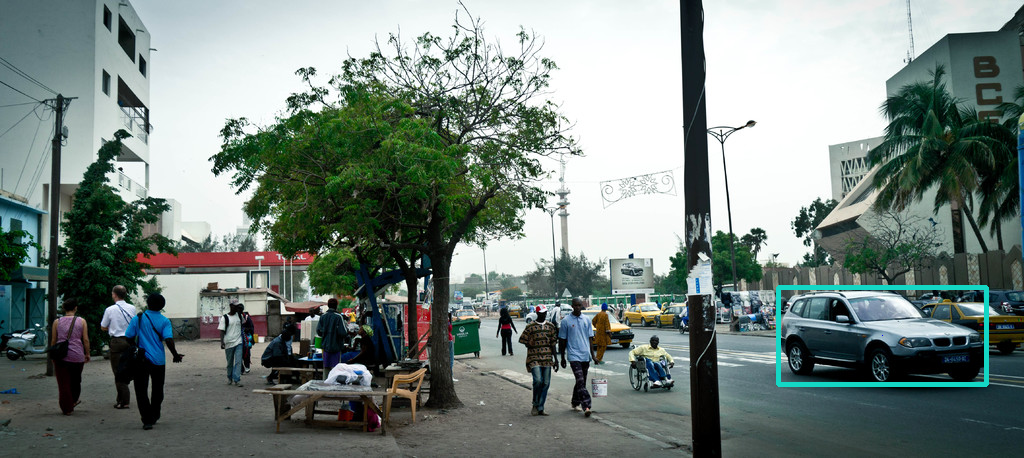

In [ ]:
visualize_bbox(image_object, bboxes)

#Exploring augmentations via albumentations

Transform pipeline (horizontal flip)

In [ ]:
transform = A.Compose(
    [A.HorizontalFlip(p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
category_ids = []
nrOfBoxes = len(BBlist)
for i in range(nrOfBoxes):
  category_ids.append(0)

In [ ]:
random.seed(7)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
cv2_imshow(transformed['image'])

In [ ]:
tbox = np.asarray(transformed['bboxes'])
tbox[0][0]

0.13874999999999987

In [ ]:
tbox.tolist()

[[0.13874999999999987, 0.7321675, 0.20375, 0.21118899999999985]]

Transform pipeline MultiplicativeNoise

In [ ]:
transform = A.Compose(
    [A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, p=1)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(4)
transformed = transform(image=image_object, bboxes=BBlist, category_ids = category_ids)
print(np.asarray(transformed['bboxes']))

[[    0.86125     0.73217     0.20375     0.21119]]


In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)

In [ ]:
visualize_bbox(transformed['image'], pd.DataFrame(tbox))

Transform pipeline channelDropout

In [ ]:
transform = A.Compose(
    [A.ChannelDropout(channel_drop_range=(1,1), fill_value=255, p=1)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(4)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)

In [ ]:
visualize_bbox(transformed['image'], tbox)

In [ ]:
# see https://github.com/albumentations-team/albumentations_examples for more examples on albumentations

In [ ]:
transform = A.Compose(
    [A.ChannelShuffle(p=1)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(5)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)
visualize_bbox(transformed['image'], tbox)

In [ ]:
transform = A.Compose(
    [A.RandomSunFlare(flare_roi=(0,0,1,0.5), angle_lower=0, angle_upper=1, num_flare_circles_lower=6, num_flare_circles_upper=10, src_radius=200, src_color=(255,255,255), p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(4)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)
visualize_bbox(transformed['image'], tbox)

In [ ]:
transform = A.Compose(
    [A.Solarize(threshold=128, always_apply=False, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(9)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)
visualize_bbox(transformed['image'], tbox)

Histogram equalization

In [ ]:
transform = A.Compose(
    [A.CLAHE()
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(9)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)
visualize_bbox(transformed['image'], tbox)

Random rotate

In [ ]:
transform = A.Compose(
    [A.RandomRotate90()
], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))

In [ ]:
random.seed(9)
transformed = transform(image=image_object, bboxes=BBlist, category_ids=category_ids)

In [ ]:
tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
tbox = tbox.iloc[:, 0:4].astype(float)
visualize_bbox(transformed['image'], tbox)

In [ ]:
tbox

,0,1,2,3
0,0.732167,0.13875,0.211189,0.20375


In [ ]:
def createCoordString(bb):
  strTest = '0' + ' ' + str(bb[1][0]) + ' ' + str(bb[1][1]) + ' ' + str(bb[1][2]) + ' ' + str(bb[1][3])

In [ ]:
boxArrayTest = []
for row in tbox.iterrows():
  bboxString = '0' +' ' + str(row[1][0]) + ' ' + str(row[1][1])+ ' ' + str(row[1][2]) + ' ' + str(row[1][3])
  boxArrayTest.append(bboxString)
boxArrayTest
for i in boxArrayTest:
  print(i)

0 0.7321675 0.13874999999999987 0.21118899999999985 0.20375


#Image augmentation on the dataset
- rotate
- solarize
- multiplicative noise

In [ ]:
trainRotateImageFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_rotate_and_original/images/'
trainRotateLabelFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_rotate_and_original/labels/'

random.seed(7)

for path in os.scandir(trainImageFolder):
    if path.is_file():
      fileNameWithoutExtension = os.path.splitext(path.name)[0]

      bboxes = pd.read_csv(trainBboxFolder+fileNameWithoutExtension+'.txt', sep=" ", names=["class", "xmin", "ymin", "xmax", "ymax"])
      bboxes.drop(columns=bboxes.columns[0], axis=1, inplace=True)
      BBlist = bboxes.to_numpy().tolist()

      category_ids = []
      nrOfBoxes = len(BBlist)
      for i in range(nrOfBoxes):
        category_ids.append(0)

      transform = A.Compose([A.RandomRotate90()], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))


      transformed = transform(image=readImage(trainImageFolder+fileNameWithoutExtension+'.jpg'), bboxes=BBlist, category_ids=category_ids)
      tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
      tbox = tbox.iloc[:, 0:4].astype(float)
      boxArrayTest = []
      for row in tbox.iterrows():
        bboxString = '0' +' ' + str(row[1][0]) + ' ' + str(row[1][1])+ ' ' + str(row[1][2]) + ' ' + str(row[1][3])
        boxArrayTest.append(bboxString)
      #print(tBoxString)
      tImage = transformed['image']
      tImageFileName = trainRotateImageFolder + fileNameWithoutExtension + '_rotate.jpg'
      #print(tImageFileName)
      tBoxFileName = trainRotateLabelFolder + fileNameWithoutExtension + '_rotate.txt'
      #print(tBoxFileName)
      cv2.imwrite(tImageFileName, tImage)
      with open(tBoxFileName, 'w') as f:
        for i in boxArrayTest:
          f.write(str(i)+"\n")

In [ ]:
trainNoiseImageFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_noise_and_original/images/'
trainNoiseLabelFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_noise_and_original/labels/'

for path in os.scandir(trainImageFolder):
    if path.is_file():
      fileNameWithoutExtension = os.path.splitext(path.name)[0]

      bboxes = pd.read_csv(trainBboxFolder+fileNameWithoutExtension+'.txt', sep=" ", names=["class", "xmin", "ymin", "xmax", "ymax"])
      bboxes.drop(columns=bboxes.columns[0], axis=1, inplace=True)
      BBlist = bboxes.to_numpy().tolist()

      category_ids = []
      nrOfBoxes = len(BBlist)
      for i in range(nrOfBoxes):
        category_ids.append(0)
      
      transform = A.Compose([A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, p=1)], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
      transformed = transform(image=readImage(trainImageFolder+fileNameWithoutExtension+'.jpg'), bboxes=BBlist, category_ids=category_ids)
      tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
      tbox = tbox.iloc[:, 0:4].astype(float)
      boxArrayTest = []
      for row in tbox.iterrows():
        bboxString = '0' +' ' + str(row[1][0]) + ' ' + str(row[1][1])+ ' ' + str(row[1][2]) + ' ' + str(row[1][3])
        boxArrayTest.append(bboxString)
      #print(tBoxString)
      tImage = transformed['image']
      tImageFileName = trainNoiseImageFolder + fileNameWithoutExtension + '_noise.jpg'
      #print(tImageFileName)
      tBoxFileName = trainNoiseLabelFolder + fileNameWithoutExtension + '_noise.txt'
      #print(tBoxFileName)
      cv2.imwrite(tImageFileName, tImage)
      with open(tBoxFileName, 'w') as f:
        for i in boxArrayTest:
          f.write(str(i)+"\n")

In [ ]:
trainSolarizeImageFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_solarize_and_original/images/'
trainSolarizeLabelFolder = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/train_solarize_and_original/labels/'

for path in os.scandir(trainImageFolder):
    if path.is_file():
      fileNameWithoutExtension = os.path.splitext(path.name)[0]

      bboxes = pd.read_csv(trainBboxFolder+fileNameWithoutExtension+'.txt', sep=" ", names=["class", "xmin", "ymin", "xmax", "ymax"])
      bboxes.drop(columns=bboxes.columns[0], axis=1, inplace=True)
      BBlist = bboxes.to_numpy().tolist()

      category_ids = []
      nrOfBoxes = len(BBlist)
      for i in range(nrOfBoxes):
        category_ids.append(0)

      transform = A.Compose([A.Solarize(threshold=128, always_apply=False, p=0.5)], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
      transformed = transform(image=readImage(trainImageFolder+fileNameWithoutExtension+'.jpg'), bboxes=BBlist, category_ids=category_ids)
      tbox = pd.DataFrame(np.asarray(transformed['bboxes']))
      tbox = tbox.iloc[:, 0:4].astype(float)
      boxArrayTest = []
      for row in tbox.iterrows():
        bboxString = '0' +' ' + str(row[1][0]) + ' ' + str(row[1][1])+ ' ' + str(row[1][2]) + ' ' + str(row[1][3])
        boxArrayTest.append(bboxString)
      #print(tBoxString)
      tImage = transformed['image']
      tImageFileName = trainSolarizeImageFolder + fileNameWithoutExtension + '_solarize.jpg'
      #print(tImageFileName)
      tBoxFileName = trainSolarizeLabelFolder + fileNameWithoutExtension + '_solarize.txt'
      #print(tBoxFileName)
      cv2.imwrite(tImageFileName, tImage)
      with open(tBoxFileName, 'w') as f:
        for i in boxArrayTest:
          f.write(str(i)+"\n")

#Transfer learning
training the YOLOv8 pretrained model on the different datasets, this can be done by changing the corresponding data yaml file.

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted"
%pwd

/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted


'/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted'

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Colab Notebooks/RM4AI/basic.yaml', batch=16, epochs=20, plots=True)

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Colab Notebooks/RM4AI/custom_solarize_original.yaml', epochs=20, plots=True)

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Colab Notebooks/RM4AI/custom_rotate_original.yaml', batch=16, epochs=20, plots=True)

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Colab Notebooks/RM4AI/custom_noise_original.yaml', batch=16, epochs=20, plots=True)

In [ ]:
model = YOLO('yolov8n.pt')
model.train(data='/content/drive/MyDrive/Colab Notebooks/RM4AI/custom.yaml', batch=16, epochs=20, plots=True)

#Visual evaluation on sample images

In [ ]:
model_basic = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/best_no_augmentation.pt')
metrics = model_basic.val()

Ultralytics YOLOv8.0.98 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 12.7MB/s]
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test/labels.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:27<00:00,  9.32s/it]
                   all         40         70      0.855       0.42      0.616      0.462
Speed: 10.3ms preprocess, 402.3ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/val


In [ ]:
#metrics.box.map50
im1_path = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/example_image1_car_small_ORIGINAL.png'
im2_path = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/example_image_2_car_distance_ORIGINAL.png'
im3_path = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/car_at_night.jpg'
im1 = readImage(im1_path)
im2 = readImage(im2_path)
im3 = readImage(im3_path)

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted"
%pwd
result_basic_im1 = model_basic.predict(source=im1, save=True)
result_basic_im2 = model_basic.predict(source=im2, save=True)
result_basic_im3 = model_basic.predict(source=im3, save=True)


0: 384x640 (no detections), 28.8ms
Speed: 3.2ms preprocess, 28.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict



/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted


0: 256x640 (no detections), 25.1ms
Speed: 2.2ms preprocess, 25.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 384x640 1 car, 20.2ms
Speed: 2.4ms preprocess, 20.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


In [ ]:
cv2_imshow(result_basic_im1[0].plot())

In [ ]:
cv2_imshow(result_basic_im2[0].plot())

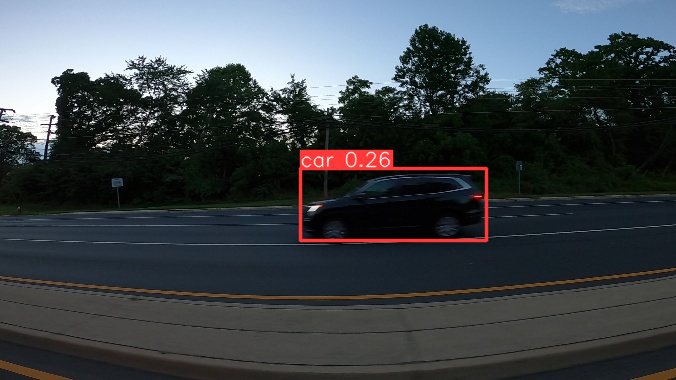

In [ ]:
cv2_imshow(result_basic_im3[0].plot())

#Testing the different models on the test set

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold
%pwd

/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold


'/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold'

In [ ]:
model_basic = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/runs/detect/train_no_augmentation_v2/weights/best.pt')

testMAPlistbasic = []

for i in range(20):
  pathString = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold' + str(i+1) + '.yaml'
  metrics = model_basic.val(pathString)
  testMAPlistbasic.append(metrics.box.map)
testMAPlistbasic

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold1/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]
                   all          5         11      0.809      0.772       0.77      0.506
Speed: 9.8ms preprocess, 304.3ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to runs/detect/val
Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold2/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mA

[0.5057093099267012,
 0.7193383778354979,
 0.7425785357142858,
 0.762630335324323,
 0.22792925109308654,
 0.6916230000000001,
 0.4256161887979385,
 0.7063448799999998,
 0.568696111044509,
 0.60141617357511,
 0.7793461578947369,
 0.7316795199999999,
 0.9220690000000001,
 0.8751099999999999,
 0.42326474862648633,
 0.5559547109557108,
 0.5122367157809166,
 0.899427,
 0.640971,
 0.5570851014070437]

In [ ]:
model_solarize = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/runs/detect/train_solarize/weights/best.pt')

testMAPlistSolarize = []

for i in range(20):
  pathString = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold' + str(i+1) + '.yaml'
  metrics = model_solarize.val(pathString)
  testMAPlistSolarize.append(metrics.box.map)
testMAPlistSolarize

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold1/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                   all          5         11      0.768      0.273      0.681      0.469
Speed: 0.3ms preprocess, 8.0ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val271
Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold2/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Image

[0.46921599006120324,
 0.5684143172294374,
 0.7371835811111109,
 0.6523915777111615,
 0.2014231804110153,
 0.78015,
 0.25762404668733596,
 0.5896447913846157,
 0.5743344198862234,
 0.5227020837801724,
 0.805528,
 0.5961448728735632,
 0.8037093333333335,
 0.8751246666666667,
 0.5346629690476191,
 0.5685362420091324,
 0.442330262386736,
 0.7755679999999999,
 0.6717659738562092,
 0.338810201761956]

In [ ]:
model_Rotate = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/runs/detect/train_rotate/weights/best.pt')

testMAPlistRotate = []

for i in range(20):
  pathString = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold' + str(i+1) + '.yaml'
  metrics = model_Rotate.val(pathString)
  testMAPlistRotate.append(metrics.box.map)
testMAPlistRotate

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold1/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
                   all          5         11      0.885      0.818      0.798      0.561
Speed: 0.3ms preprocess, 7.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val291
Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold2/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Image

[0.5614778346810422,
 0.802501716001716,
 0.7552966870263546,
 0.8131926586174242,
 0.32650434610674633,
 0.7067939556649792,
 0.40792452077075925,
 0.7580295261572172,
 0.5563871027061544,
 0.6459049957078341,
 0.8135759354365371,
 0.7229070952380952,
 0.8955,
 0.8621132848043678,
 0.3710530498578261,
 0.5119209417845259,
 0.4718537023971054,
 0.8784316479400749,
 0.6888941898322064,
 0.6737539295947473]

In [ ]:
model_Noise = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/runs/detect/train_noise_best/weights/best.pt')

testMAPlistNoise = []

for i in range(20):
  pathString = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold' + str(i+1) + '.yaml'
  metrics = model_Noise.val(pathString)
  testMAPlistNoise.append(metrics.box.map)
testMAPlistNoise

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold1/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
                   all          5         11      0.884      0.698       0.71      0.489
Speed: 0.3ms preprocess, 6.0ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val311
Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold2/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Image

[0.4888850341997265,
 0.8030417816600324,
 0.7801057349081365,
 0.8295347428993225,
 0.3156527783386522,
 0.7654558554437327,
 0.34945655228440553,
 0.7318453427818661,
 0.5288895104455433,
 0.617406721785539,
 0.8955,
 0.6931128127853883,
 0.9052900197628458,
 0.7622416666666666,
 0.3709743796450254,
 0.49872108926900277,
 0.5496007341065525,
 0.891083944580277,
 0.7178851648351647,
 0.63696471157347]

In [ ]:
model_combined = YOLO('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/runs/detect/train_combinedAugmentation/weights/best.pt')

testMAPlistCombined = []

for i in range(20):
  pathString = '/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold' + str(i+1) + '.yaml'
  metrics = model_combined.val(pathString)
  testMAPlistCombined.append(metrics.box.map)
testMAPlistCombined

Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold1/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]
                   all          5         11      0.864      0.636      0.684      0.477
Speed: 1.7ms preprocess, 220.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val21
Ultralytics YOLOv8.0.103 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
val: Scanning /content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/fold2/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  

[0.47655263701763334,
 0.8686242062541585,
 0.8476981718719875,
 0.8300512291666667,
 0.29402167492206277,
 0.7012172588954692,
 0.41195231536815413,
 0.7355846801619434,
 0.5039546530661003,
 0.6492007922914146,
 0.7560855268091489,
 0.6900084907834101,
 0.8654688841201716,
 0.8117400932400933,
 0.32955526109369965,
 0.4764698867024447,
 0.48361407107083226,
 0.9949999999999999,
 0.7565924625468166,
 0.7158003325325372]

#Statistical analysis of the results
- one way anova
- tukey HSD

In [ ]:
import scipy.stats as stats
import pandas as pd
df = pd.DataFrame(list(zip(testMAPlistbasic, testMAPlistSolarize, testMAPlistRotate, testMAPlistNoise, testMAPlistCombined)), columns=['No augmentation', "Solarize", "Rotate", "Noise", "Combined"])
df
df.to_excel("results_map50_95.xlsx")

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold'

In [ ]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['No augmentation', 'Solarize', 'Rotate', 'Noise', 'Combined'])
df_melt

,index,variable,value
0,0,No augmentation,0.505709
1,1,No augmentation,0.719338
2,2,No augmentation,0.742579
3,3,No augmentation,0.762630
4,4,No augmentation,0.227929
...,...,...,...
95,15,Combined,0.476470
96,16,Combined,0.483614
97,17,Combined,0.995000
98,18,Combined,0.756592


In [ ]:
df_melt.columns = ['Index', 'Method', 'mAP50_95']
df_melt

,Index,Method,mAP50_95
0,0,No augmentation,0.505709
1,1,No augmentation,0.719338
2,2,No augmentation,0.742579
3,3,No augmentation,0.762630
4,4,No augmentation,0.227929
...,...,...,...
95,15,Combined,0.476470
96,16,Combined,0.483614
97,17,Combined,0.995000
98,18,Combined,0.756592


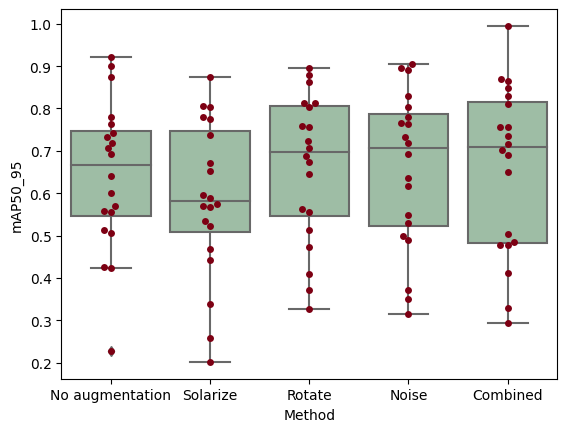

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='Method', y='mAP50_95', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="Method", y="mAP50_95", data=df_melt, color='#7d0013')
plt.show()

In [ ]:
fvalue, pvalue = stats.f_oneway(df['No augmentation'], df['Solarize'], df['Rotate'], df['Noise'], df['Combined'])
print(fvalue, pvalue)

0.5631785440037204 0.6899434437823275


In [ ]:


# ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('mAP50_95 ~ C(Method)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

In [ ]:
import pandas as pd
dfMAP50 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/results_map50.xlsx', index_col=None)

In [ ]:
from scipy.stats import tukey_hsd
res = tukey_hsd(dfMAP50['No augmentation'], dfMAP50['Solarize'], dfMAP50['Rotate'], dfMAP50['Noise'], dfMAP50['Combined'])
print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.059     0.837    -0.098     0.216
 (0 - 2)     -0.029     0.985    -0.187     0.128
 (0 - 3)     -0.018     0.998    -0.175     0.139
 (0 - 4)     -0.036     0.968    -0.193     0.121
 (1 - 0)     -0.059     0.837    -0.216     0.098
 (1 - 2)     -0.088     0.526    -0.245     0.069
 (1 - 3)     -0.077     0.657    -0.234     0.081
 (1 - 4)     -0.095     0.453    -0.252     0.062
 (2 - 0)      0.029     0.985    -0.128     0.187
 (2 - 1)      0.088     0.526    -0.069     0.245
 (2 - 3)      0.012     1.000    -0.146     0.169
 (2 - 4)     -0.007     1.000    -0.164     0.151
 (3 - 0)      0.018     0.998    -0.139     0.175
 (3 - 1)      0.077     0.657    -0.081     0.234
 (3 - 2)     -0.012     1.000    -0.169     0.146
 (3 - 4)     -0.018     0.998    -0.175     0.139
 (4 - 0)      0.036     0.968    -0.121     0.193
 (4 - 1)      0.095     0.453   

In [ ]:
from statstmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd()
print(m_comp)

In [ ]:
df_melt = pd.melt(dfMAP50.reset_index(), id_vars=['index'], value_vars=['No augmentation', 'Solarize', 'Rotate', 'Noise', 'Combined'])

df_melt.columns = ['Index', 'Method', 'mAP50_95']
df_melt

# ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('mAP50_95 ~ C(Method)', data=df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Method),0.116431,4.0,0.910776,0.461009
Residual,3.036135,95.0,NaN,NaN


In [ ]:
dfMAP5095 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/RM4AI/cars/car/splitted/test_40fold/results_map50_95.xlsx', index_col=None)
res2 = tukey_hsd(dfMAP5095['No augmentation'], dfMAP5095['Solarize'], dfMAP5095['Rotate'], dfMAP5095['Noise'], dfMAP5095['Combined'])
print(res2)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.054     0.883    -0.107     0.216
 (0 - 2)     -0.019     0.998    -0.180     0.143
 (0 - 3)     -0.014     0.999    -0.175     0.147
 (0 - 4)     -0.018     0.998    -0.179     0.144
 (1 - 0)     -0.054     0.883    -0.216     0.107
 (1 - 2)     -0.073     0.718    -0.234     0.088
 (1 - 3)     -0.068     0.764    -0.230     0.093
 (1 - 4)     -0.072     0.731    -0.233     0.090
 (2 - 0)      0.019     0.998    -0.143     0.180
 (2 - 1)      0.073     0.718    -0.088     0.234
 (2 - 3)      0.005     1.000    -0.157     0.166
 (2 - 4)      0.001     1.000    -0.160     0.163
 (3 - 0)      0.014     0.999    -0.147     0.175
 (3 - 1)      0.068     0.764    -0.093     0.230
 (3 - 2)     -0.005     1.000    -0.166     0.157
 (3 - 4)     -0.003     1.000    -0.165     0.158
 (4 - 0)      0.018     0.998    -0.144     0.179
 (4 - 1)      0.072     0.731   